this notebook up-sampling only using resample

#### Import Dependencies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import pandas_profiling

import itertools

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels # for confusion matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#### Data Dictionary

**Data Dictionary**

- pol_eff_dt - auto insurance policy effective date
- gender - gender of driver: F, M
- agecat - driver's age category: 1 (youngest), 2, 3, 4, 5, 6
- credit_score - driver’s credit score(integer): 1-100, 1=poor, 100=excellent
- area - driver's area of residence: A, B, C, D, E, F
- traffic_index - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average
- veh_age - age of vehicle(categorical): 1 (youngest), 2, 3, 4
- veh_body - vehicle body, coded as:
    - BUS
    - CONVT = convertible  
    - COUPE   
    - HBACK = hatchback                  
    - HDTOP = hardtop
    - MCARA = motorized caravan
    - MIBUS = minibus
    - PANVN = panel van
    - RDSTR = roadster
    - SEDAN    
    - STNWG = station wagon
    - TRUCK           
    - UTE = utility
- veh_value - vehicle value, in \\$10,000s
- claim_office - office location of claim handling agent: A, B, C, D
- traffic2 - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average.  Null values have imputed mean of full dataset
- veh_value2 - vehicle value, in \\$10,000s. Null values have been replaces with the mean of the full dataset
- veh_value3 - vehicle value, in \\$10,000s. Null values have been replaces with the median of the full dataset
- veh_age2 - age of vehicle(categorical): 1 (youngest), 2, 3, 4.  Null values have been replaces with the most frequent category, which is 2
- credit2 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the mean of the full dataset
- credit3 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the median of the full dataset
- dob - driver's date of birth
- age - Driver's age at policy effective date
- claim_ind - Indicates if the policy had a claim (=1) or not
- veh_body2 - vehicle body, with a collapsed type coding, as described below.  Original coding on left, new coding on right:
    - 'BUS' = 'MIBUS',
    - 'CONVT' = 'HDTOP'
    - 'COUPE' = 'COUPE'
    - 'HBACK' = 'HBACK'
    - 'HDTOP' = 'HDTOP'
    - 'MCARA' = 'MIBUS'
    - 'MIBUS' = 'MIBUS'
    - 'PANVN' = 'PANVN'
    - 'RDSTR' = 'HDTOP'
    - 'SEDAN' = 'SEDAN'
    - STNWG' = 'STNWG'
    - 'TRUCK' = 'TRUCK'
    - 'UTE' = 'UTE'

- numclaims - number of claims(integer): 0 if no claim
- claimcst0 - claim amount: 0 if no claim.  This is the total one year claim amount (ultimate loss) for the policy. 


#### DataFrame Dictionary

# Obtaining the Data

In [2]:
data = pd.read_csv('autoinsurance_claims.csv')
data.head()

,pol_number,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,traffic2,veh_value2,veh_value3,veh_age2,credit2,credit3,dob,age,claim_ind,veh_body2,numclaims,claimcst0
0,80750205,7/1/2015,M,4,52.0,C,93.0,4.0,STNWG,2.96,NaN,93,2.96,2.96,4,52.000000,52,2/18/1963,53,0,STNWG,0,0.0
1,90994433,8/1/2015,M,3,83.0,C,108.0,4.0,SEDAN,1.89,NaN,108,1.89,1.89,4,83.000000,83,2/18/1978,38,0,SEDAN,0,0.0
2,59239520,7/1/2015,M,5,71.0,A,NaN,3.0,SEDAN,2.75,NaN,100,2.75,2.75,3,71.000000,71,4/14/1960,56,0,SEDAN,0,0.0
3,67030771,11/1/2015,M,3,NaN,B,77.0,3.0,UTE,2.92,NaN,77,2.92,2.92,3,74.730883,81,12/23/1974,41,0,UTE,0,0.0
4,91422215,8/1/2015,M,2,88.0,D,NaN,4.0,STNWG,3.63,NaN,100,3.63,3.63,4,88.000000,88,12/25/1984,31,0,STNWG,0,0.0


In [3]:
data.shape

(60948, 23)

In [4]:
data.numclaims.value_counts()

0    56787
1     3907
2      236
3       17
4        1
Name: numclaims, dtype: int64

# Preprocessing

In [5]:
# looking for null values
data.isnull().sum()

pol_number           0
pol_eff_dt           0
gender               0
agecat               0
credit_score      3014
area                 0
traffic_index    12250
veh_age          10476
veh_body             0
veh_value         7562
claim_office     56787
traffic2             0
veh_value2           0
veh_value3           0
veh_age2             0
credit2              0
credit3              0
dob                  0
age                  0
claim_ind            0
veh_body2            0
numclaims            0
claimcst0            0
dtype: int64

__Dropping Columns__

In [6]:
# claim office is mostly empty; lets drop the feature
# we don't need the policy number either
# veh_body and veh_body2 are equal, keep veh_body2 as it is updated
# the dateTime columns create a complexity we could do without and tell us nothing since they are not the focus
  ## of the data.
# pol_eff_dt is proprietary info we don't need and dob is redundant since we have age. 
  
data.drop(['claim_office', 'pol_number', 'veh_body', 'pol_eff_dt', 'dob'], axis = 1, inplace = True)

there are duplicate columns for credit_score, traffic_index, vehicle_value, containing null values, where either the mean, median or both were used to impute missing values.  Lets keep only columns with median imputation

In [7]:
# drop credit_score and credit2 columns
# drop veh_age column.  vehicle age also has a duplicate column, where the mode was used for null values. 
  ##This is an ordinal value so keeping the mode for imputation makes sense
data.drop(['credit_score', 'credit2', 'traffic_index', 'veh_value', 'veh_value2', 'veh_age'], axis = 1, inplace = True)

In [8]:
# confirm we have no other null values
data.isnull().sum()

gender        0
agecat        0
area          0
traffic2      0
veh_value3    0
veh_age2      0
credit3       0
age           0
claim_ind     0
veh_body2     0
numclaims     0
claimcst0     0
dtype: int64

**Fix Data Types**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null object
agecat        60948 non-null int64
area          60948 non-null object
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null int64
veh_body2     60948 non-null object
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: float64(2), int64(7), object(3)
memory usage: 5.6+ MB




| Feature | Change Type to: |
|------------|---------------------|
| gender | change to category |
| agecat | change to category |
| area | change to category |
| veh_age2 | change to category |
| claim_ind | change to category |
| veh_body2 | change to category |


In [10]:
data = data.astype({'gender':'category', 'area':'category', 
             'claim_ind':'category', 'veh_body2':'category'}, inplace = True)

In [11]:
# double check the work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null category
agecat        60948 non-null int64
area          60948 non-null category
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null category
veh_body2     60948 non-null category
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: category(4), float64(2), int64(6)
memory usage: 4.0 MB


**Edit Column Names**

Lets change a few of the column names for ease of use as we move forward and work with the data

In [12]:
data.rename(columns={'traffic2':'traffic_index', 'veh_value3':'veh_value00', 'credit3':'credit_score', 'numclaims':'num_claims', 
             'claimcst0':'claim_amount', 'veh_age2':'veh_ageIndex'}, inplace=True)

In [15]:
data.to_csv('clean_data.csv')

**Look for Multicolinearity**

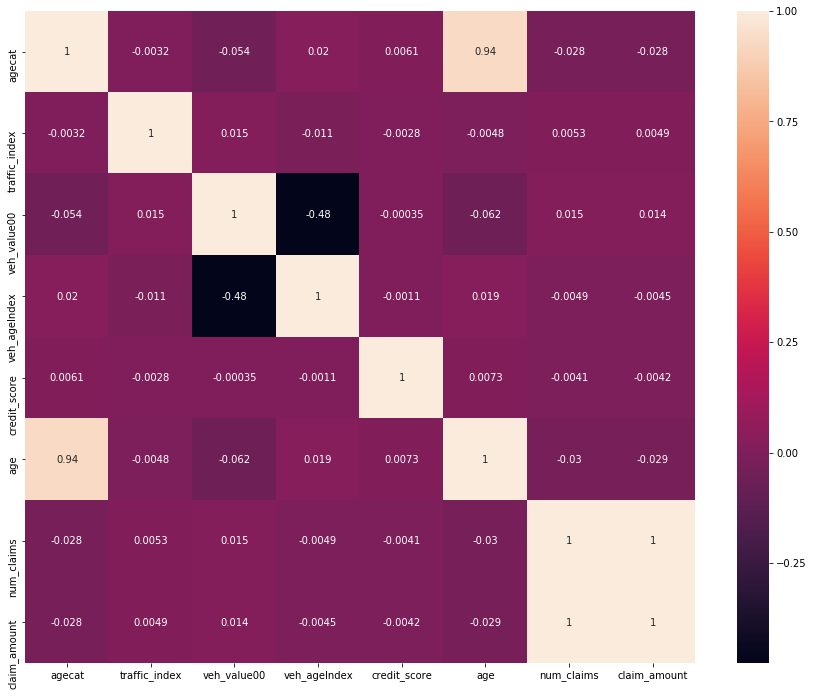

In [16]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True)

**Split data set between categorical and continuous to check distributions** which should help us decide which features to drop

I will treat ordinal features as numeric data.  Doing this requires the assumption that the numeric space between each category is equal or close to equal.   To ignore the ordering would essentially mean we could delete columns for the drivers age, the traffic index, vehicle age and credit score; that would be too much useful information to lose and an extreme downside.  The downside to treating this data as numeric is that if the spread between bins are not equal, then our results may only be approximate.  I would posit that the approximate results would be more accurate than any model that disregarded them. 

In [17]:
# create continuous sub-DataFrame

continuous = data.copy()
for i in continuous:
    if continuous[i].dtype.name == 'category':
        continuous.drop(i, axis=1, inplace = True)
continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 8 columns):
agecat           60948 non-null int64
traffic_index    60948 non-null int64
veh_value00      60948 non-null float64
veh_ageIndex     60948 non-null int64
credit_score     60948 non-null int64
age              60948 non-null int64
num_claims       60948 non-null int64
claim_amount     60948 non-null float64
dtypes: float64(2), int64(6)
memory usage: 3.7 MB


In [18]:
continuous.head()

,agecat,traffic_index,veh_value00,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,4,93,2.96,4,52,53,0,0.0
1,3,108,1.89,4,83,38,0,0.0
2,5,100,2.75,3,71,56,0,0.0
3,3,77,2.92,3,81,41,0,0.0
4,2,100,3.63,4,88,31,0,0.0


In [19]:
continuous.num_claims.value_counts()

0    56787
1     3907
2      236
3       17
4        1
Name: num_claims, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000259B016C9B0>,
      dtype=object)

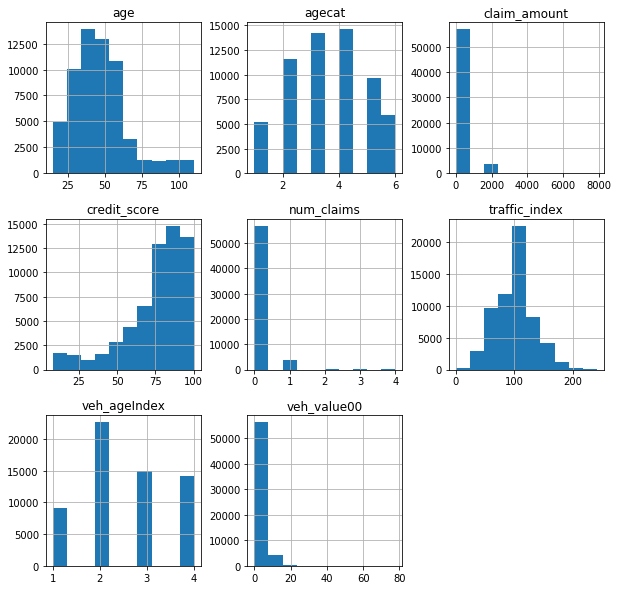

In [20]:
# inspect distributions for continuous data
continuous.hist(figsize=(10,10))

we have colinearity between:
- age & agecat
- num_claims & claim_amount  
lets drop age since agecat looks like a better distribution.  
claim amount and num_claims end up distorting the models so lets drop them both. 

In [21]:
def print_value_counts(df):
    
    for col in df:
        print(col,':')
        print(df[col].value_counts(),'\n')
print_value_counts(continuous)

agecat :
4    14585
3    14177
2    11539
5     9634
6     5853
1     5160
Name: agecat, dtype: int64 

traffic_index :
100    12760
76       562
72       558
84       544
77       544
75       531
86       527
79       516
80       508
82       507
90       503
91       503
81       502
66       499
73       497
74       497
78       496
89       491
87       488
69       486
93       485
65       483
98       481
83       481
70       477
85       474
71       470
63       468
96       462
102      461
       ...  
5          5
4          5
205        5
0          4
208        4
217        4
9          4
204        4
13         4
206        4
212        3
8          3
203        3
224        3
2          3
220        2
216        2
1          2
215        2
6          2
3          2
241        1
230        1
235        1
11         1
232        1
218        1
221        1
222        1
223        1
Name: traffic_index, Length: 228, dtype: int64 

veh_value00 :
3.38     7942
3.06      

In [ ]:
# log transform
cont_log = np.log(continuous)

In [ ]:
cont_log.num_claims.value_counts()

In [ ]:
cont_log.replace(-np.inf, np.nan, inplace=True)
cont_log.replace(np.nan, 0, inplace=True)

In [ ]:
cont_log.num_claims.value_counts()

In [ ]:
# inspect distributions for continuous data
cont_log.hist(figsize=(10,10))

veh_value, claim_amount and num_claims are so heavily skewed that it doesnt make sense to keep the columns.  In addition, the multicolinearity presents a problem.

In [ ]:
cont_log.head()

**remove features causing multicolinearity**

In [ ]:
cont_log.drop(['num_claims', 'claim_amount', 'veh_value00', 'agecat'],axis=1, inplace=True)

In [ ]:
# create categorical sub-DataFrame

categorical = data.copy()
for i in categorical:
    if categorical[i].dtype.name != 'category':
        categorical.drop(i, axis = 1, inplace=True)
categorical.info()

**Get Dummies for categorical data**

In [ ]:
categorical.head()

In [ ]:
categorical.info()

In [ ]:
categorical.veh_body2.value_counts()

In [ ]:
# one-hot encode categorical data
dummies = pd.get_dummies(categorical.drop('claim_ind', axis=1))
dummies.head()

In [ ]:
dummies.info()

**concat the continuous and categorical DataFrames**

In [ ]:
#beginning processed dataframe
df = pd.concat([cont_log, dummies, categorical.claim_ind], axis = 1, sort=False)
df.head()

In [ ]:
df.info()

In [ ]:
pandas_profiling.ProfileReport(df)

In [ ]:
df.info()

# Logistic Regression Model

Lets check for any class imbalance in our target variable

In [ ]:
df.claim_ind.value_counts()

Roughly 7% of the target data are True while 93% are False so, it looks like we do have class imbalance and will run SMOTE to fix it.

## Logistic Regression Model #1

In [ ]:
# define X and y 
X = df[df.columns[:-1]].copy()
y = df.claim_ind.copy()

In [ ]:
# split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
# concatenate our training data back together
training_data = pd.concat([X_train, y_train], axis=1)

In [ ]:
len(y_train)

In [ ]:
# separate minority and majority classes
no_claim = training_data[training_data.claim_ind==0]
file_claim = training_data[training_data.claim_ind==1]

In [ ]:
print(len(no_claim))
print(len(file_claim))

In [ ]:
# upsample minority
file_claim_upsampled = resample(file_claim,
                          replace=True, # sample with replacement
                          n_samples=len(no_claim), # match number in majority class
                          random_state=42) # reproducible results

In [ ]:
len(file_claim_upsampled)

In [ ]:
type(file_claim_upsampled)
file_claim_upsampled.head()

In [ ]:
# combine majority and upsampled minority
upsampled = pd.concat([file_claim_upsampled, no_claim])

In [ ]:
upsampled.head()

In [ ]:
upsampled.claim_ind.value_counts()

In [ ]:
len(upsampled)

In [ ]:
X_train_up = upsampled.drop(['claim_ind'], axis = 1) 
y_train_up = upsampled.claim_ind

In [ ]:
len(X_train)

**fit a model**

In [ ]:
# create a Logistic Regression Object
logreg_classifier = LogisticRegression()

# fit a logistic regression model with default parameters
logreg_model = logreg_classifier.fit(X_train_up, y_train_up)
print(logreg_model)

In [ ]:
# using model to generate predictions off training data
y_hat_train = logreg_model.predict(X_train_up)
# using model to generate predictions off test data
y_hat_test = logreg_model.predict(X_test)

In [ ]:
print(f" Accuracy score on training data: {round(accuracy_score(y_train_up, y_hat_train),2)}")
print(f" Accuracy score on test data: {round(accuracy_score(y_test, y_hat_test),2)}")

In [ ]:
print(classification_report(y_test,y_hat_test))

In [ ]:
# Confusion Matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

show_cf(y_test, y_hat_test)

In [ ]:
# calculate and plot ROC curve

y_score = logreg_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest Models

## RF Model #1

In [ ]:
RF_X_train = X_train_up.copy()
RF_y_train = y_train_up.copy()

RF_X_test = X_test.copy()
RF_y_test = y_test.copy()

In [ ]:
RForest = RandomForestClassifier(n_estimators=100, max_depth= 5)
RForest.fit(RF_X_train, RF_y_train)

In [ ]:
RF_pred = RForest.predict(RF_X_test)

print(accuracy_score(RF_y_test, RF_pred))
print(confusion_matrix(RF_y_test, RF_pred))
print(classification_report(RF_y_test, RF_pred))

In [ ]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances(RForest, RF_X_train)

In [ ]:
for name, importance in zip(RF_X_train.columns, RForest.feature_importances_):
    print(name, "=", f"{round(importance*100)}'%'")

### lets drop any feature scoring less than 5% and run the model again.

## RF Model #2

- keep features with importance > 0.05

In [ ]:
X_train_up.info()

In [ ]:
RF_X_train_2 = X_train_up[['age', 'credit_score', 'veh_ageIndex', 'traffic_index']]
RF_y_train_2 = y_train_up

RF_X_test_2 = X_test[['age', 'credit_score', 'veh_ageIndex', 'traffic_index']]
RF_y_test_2 = y_test

In [ ]:
# create a random forest classifier object
RForest_2 = RandomForestClassifier(n_estimators=100, max_depth= 5)

# fit the model
RForest_2.fit(RF_X_train_2, RF_y_train_2)

# generate predictions
pred_2 = RForest_2.predict(RF_X_test_2)

In [ ]:
print(f" Accuracy RF model #2: {accuracy_score(RF_y_test_2, pred_2 )}")
print(confusion_matrix(RF_y_test_2, pred_2))
print(classification_report(RF_y_test_2, pred_2))

In [ ]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(RForest_2, RF_X_train_2)

In [ ]:
show_cf(RF_y_test_2, pred_2)

# XGBoost

## XGBoost Model #1

**reample**

In [ ]:
X_train_boost = X_train_up
y_train_boost = y_train_up

X_test_boost = X_test
y_test_boost = y_test

In [ ]:
X_test_boost.info()

In [ ]:
# create an XGBoost classifier object
clf = xgb.XGBClassifier()

# use XGBoost to fit our x and y training data
clf.fit(X_train_boost, y_train_boost)

# generate predictions using training features
boost_training_preds = clf.predict(X_train_boost)

# generate predictions using test features
boost_test_preds = clf.predict(X_test_boost)



In [ ]:
training_accuracy = accuracy_score(y_train_boost, boost_training_preds)
test_accuracy = accuracy_score(y_test_boost, boost_test_preds)

#print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

In [ ]:
print(confusion_matrix(y_test_boost, boost_test_preds))
print(classification_report(y_test_boost, boost_test_preds))

In [ ]:
show_cf(y_test_boost, boost_test_preds)

In [ ]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(clf, X_train_boost) # training data param here is just to get column headers for graph

the XGBoost is performing the best.  Lets further optimize with Grid Search

## XGBoost Model #2


**resample with feature_importance**

In [ ]:
X_train_boost = X_train_up[['age', 'credit_score', 'veh_ageIndex', 'traffic_index']]
y_train_boost = y_train_up

X_test_boost = X_test[['age', 'credit_score', 'veh_ageIndex', 'traffic_index']]
y_test_boost = y_test

In [ ]:
X_test_boost.info()

In [ ]:
# create an XGBoost classifier object
clf = xgb.XGBClassifier()

# use XGBoost to fit our x and y training data
clf.fit(X_train_boost, y_train_boost)

# generate predictions using training features
boost_training_preds = clf.predict(X_train_boost)

# generate predictions using test features
boost_test_preds = clf.predict(X_test_boost)



In [ ]:
training_accuracy = accuracy_score(y_train_boost, boost_training_preds)
test_accuracy = accuracy_score(y_test_boost, boost_test_preds)

#print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

In [ ]:
print(confusion_matrix(y_test_boost, boost_test_preds))
print(classification_report(y_test_boost, boost_test_preds))

In [ ]:
show_cf(y_test_boost, boost_test_preds)

In [ ]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(clf, X_train_boost) # training data param here is just to get column headers for graph

the XGBoost is performing the best.  Lets further optimize with Grid Search

In [ ]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [7],
    'min_child_weight': [9],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250, 500, 1000]
    
}

In [ ]:
import time
start = time.time()

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_boost, y_train_boost)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_boost)
test_preds = grid_clf.predict(X_test_boost)
training_accuracy = accuracy_score(y_train_boost, training_preds)
test_accuracy = accuracy_score(y_test_boost, test_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

end = time.time()
print(end - start)